
0: 640x448 1 person, 13.3ms
Speed: 1.2ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 448)
Detected 17 keypoints


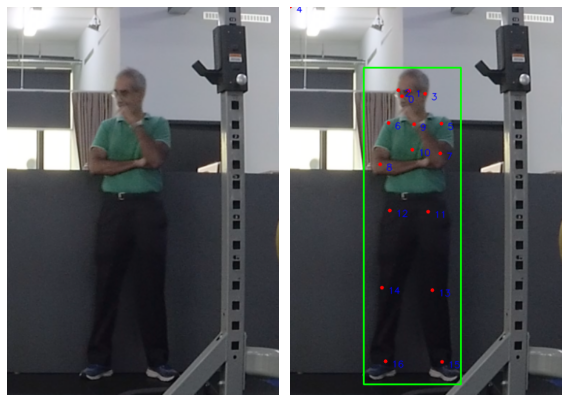

In [1]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

img = cv2.imread("./img.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (32*14, 640))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
model = YOLO("yolo11n-pose.pt") 
x = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0
x = x.unsqueeze(0)
o = model(x)  # dry run
bbox = o[0].boxes.data[o[0].boxes.conf > 0.75]
for b in bbox:
    x1, y1, x2, y2 = b[:4]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
keypoints = o[0].keypoints.data[o[0].keypoints.conf > 0.0]
num_keypoints = len(keypoints)
print(f"Detected {num_keypoints} keypoints")


points = []
for i in range(num_keypoints):
    x, y = keypoints[i,:2]
    x, y = int(x), int(y)
    points.append((x, y))
    cv2.circle(img, (x, y), 3, (255, 0, 0), -1)  # 점 찍기
    cv2.putText(img, str(i), (x+10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()


In [2]:
label2key = {0:"Nose",
             1:"Left Eye",
             2:"Right Eye",
             3:"Left Ear",
             4:"Right Ear",
             5:"Left Shoulder",
             6:"Right Shoulder",
             7:"Left Elbow",
             8:"Right Elbow",
             9:"Left Wrist",
             10:"Right Wrist",
             11:"Left Hip",
             12:"Right Hip",
             13:"Left Knee",
             14:"Right Knee",
             15:"Left Ankle",
             16:"Right Ankle"}

key2label = {v:k for k, v in label2key.items()}

torch.Size([1, 17, 3])


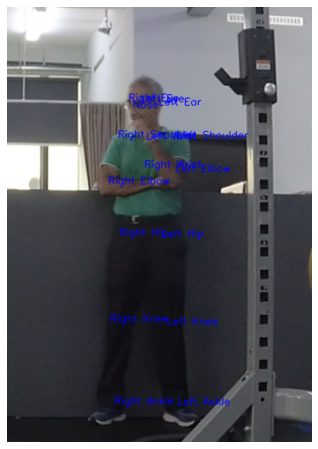

In [3]:
img = cv2.imread("./img.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (32*14, 640))
print(o[0].keypoints.data.shape)
x,y,c = o[0].keypoints.data[0].permute(1,0)
plt.figure(figsize=(8, 8))
for i in range(num_keypoints):
    x, y, c = keypoints[i]
    x, y = int(x), int(y)
    if c < 0.5:
        pass
    else:
        cv2.putText(img, label2key[i], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
plt.imshow(img)
plt.axis("off")
plt.show()


In [4]:
results = model(source="./data/CDJ1/CDJ1.MP4")



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/109) /home/eis/Workspace/Kichang/gym/data/CDJ1/CDJ1.MP4: 640x384 3 persons, 17.1ms
video 1/1 (frame 2/109) /home/eis/Workspace/Kichang/gym/data/CDJ1/CDJ1.MP4: 640x384 3 persons, 8.0ms
video 1/1 (frame 3/109) /home/eis/Workspace/Kichang/gym/data/CDJ1/CDJ1.MP4: 640x384 3 persons, 8.2ms
video 1/1 (frame 4/109) /home/eis/Workspace/Kichang/gym/data/CDJ1/CDJ1.MP4: 640x384 3 persons, 7.9ms
video 1/1 (frame 5/109) /home/eis/Workspace/Kichang

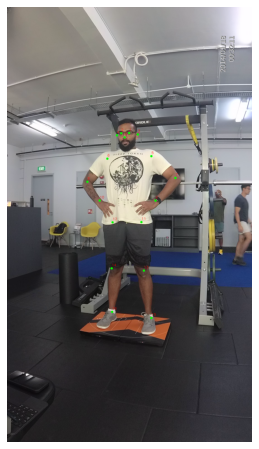

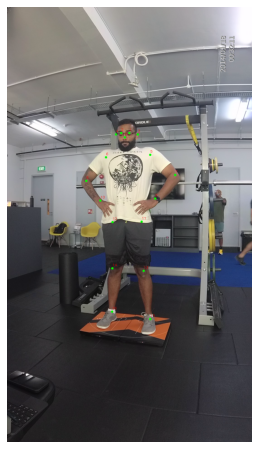

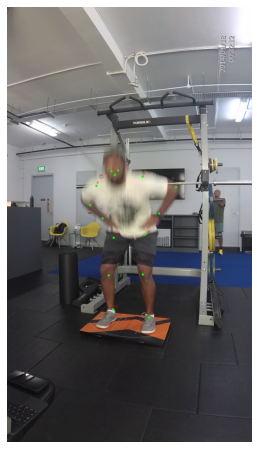

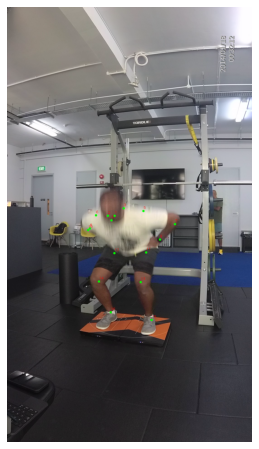

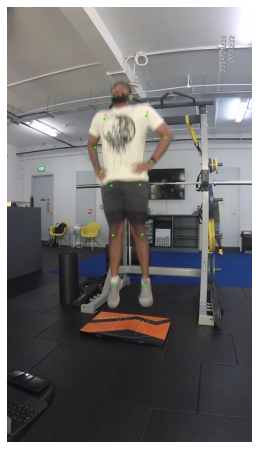

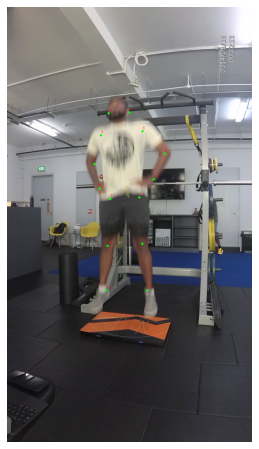

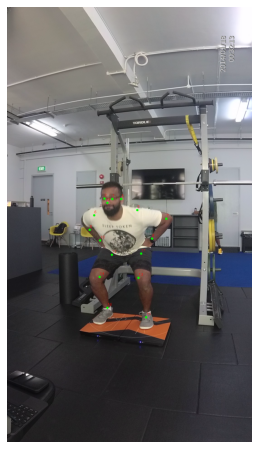

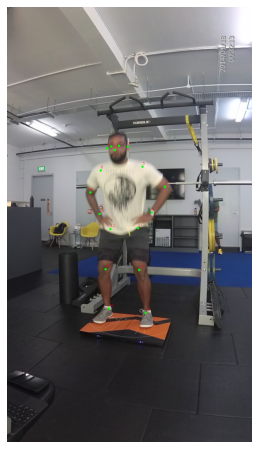

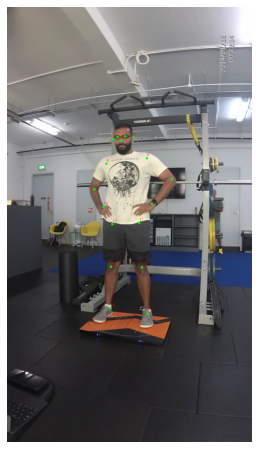

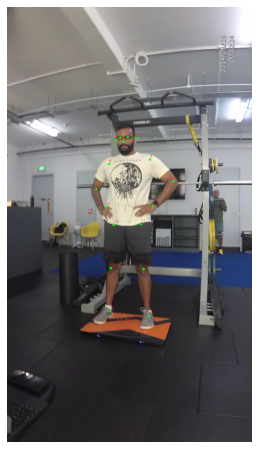

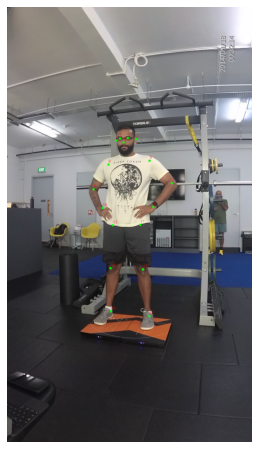

In [5]:
keypoint_trace = {k:[] for k, v in label2key.items()}

for r_idx, result in enumerate(results):
    if r_idx % 10 == 0:
        plt.figure(figsize=(8, 8))
    image = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
    keypoints = result.keypoints.xy  # Shape: (num_people, 17, 2) -> (x, y)
    keypoints_conf = result.keypoints.conf  # Shape: (num_people, 17) -> Confidence

    for person_idx, person_kpts in enumerate(keypoints):
        if person_idx != 0:
            pass
        else:
            for idx, (x, y) in enumerate(person_kpts):            
                confidence = keypoints_conf[person_idx][idx]
                if confidence > 0.5:  # Draw only reliable keypoints
                    cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
                    cv2.putText(image, str(idx), (int(x), int(y)-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                keypoint_trace[idx].append(np.array([x.cpu(), y.cpu()]))
    if r_idx % 10 == 0:
        plt.imshow(image)
        plt.axis("off")
        plt.show()


In [39]:
keypoints_array = np.array(keypoint_trace[0])
np.array(keypoint_trace[16])[0,1]-np.array(keypoint_trace[0])[0,1]
(150/770)*175

34.09090909090909

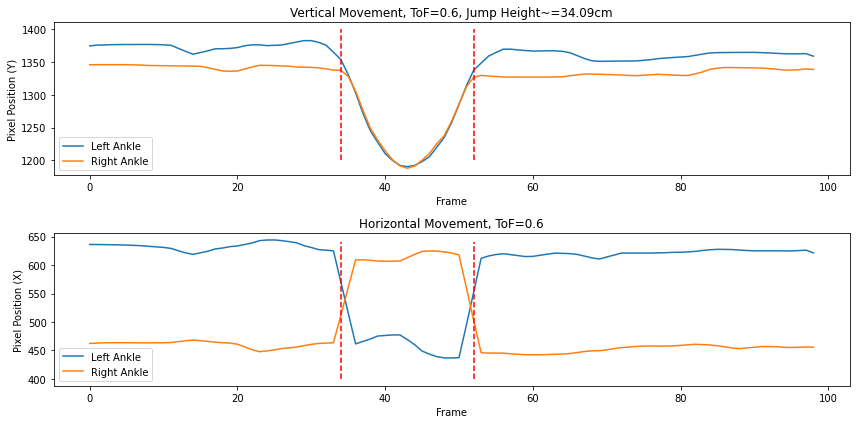

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
# moving average filter
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Median filter 적용할 윈도우 크기 (홀수여야 함)
kernel_size = 5
plt.figure(figsize=(12, 6))

for keypoint_idx in range(15,17):  # 17개의 키포인트
    keypoints_array = np.array(keypoint_trace[keypoint_idx])  # (frames, 2)
    x_vals = keypoints_array[:, 0]  # 수평 움직임
    y_vals = keypoints_array[:, 1]  # 수직 움직임
    
    # Median filter 적용
    x_vals_smooth = moving_average(medfilt(x_vals, kernel_size))
    y_vals_smooth = moving_average(medfilt(y_vals, kernel_size))
    
    # 수직 움직임 (y 좌표)
    plt.subplot(2, 1, 1)
    plt.plot(range(len(y_vals_smooth)), y_vals_smooth, label=f"{label2key[keypoint_idx]}")
    
    # 수평 움직임 (x 좌표)
    plt.subplot(2, 1, 2)
    plt.plot(range(len(x_vals_smooth)), x_vals_smooth, label=f"{label2key[keypoint_idx]}")

# 그래프 설정
plt.subplot(2, 1, 1)
plt.title(f"Vertical Movement, ToF={(52-34)*(1/30)}, Jump Height~={(150/770)*175:.2f}cm")
plt.xlabel("Frame")
plt.ylabel("Pixel Position (Y)")
plt.legend()
plt.vlines(x=[34, 52], ymin=1200, ymax=1400, colors='r', linestyles='dashed')

plt.subplot(2, 1, 2)
plt.title(f"Horizontal Movement, ToF={(52-34)*(1/30)}")
plt.xlabel("Frame")
plt.ylabel("Pixel Position (X)")
plt.legend()
plt.vlines(x=[34, 52], ymin=400, ymax=640, colors='r', linestyles='dashed')

plt.tight_layout()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


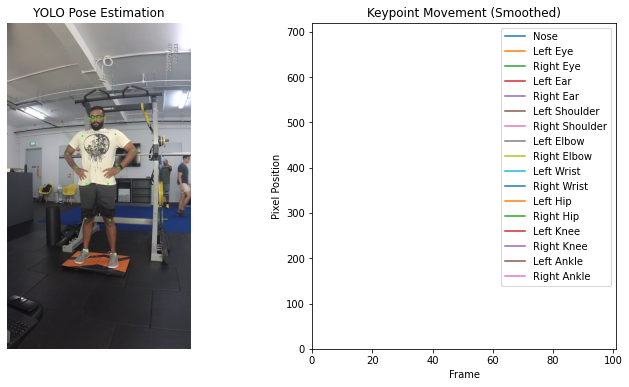

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import medfilt

# Median filter를 위한 커널 크기
kernel_size = 5

# Figure 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax_video, ax_plot = axes

# 그래프 초기화
ax_video.set_title("YOLO Pose Estimation")
ax_video.axis("off")

ax_plot.set_title("Keypoint Movement (Smoothed)")
ax_plot.set_xlabel("Frame")
ax_plot.set_ylabel("Pixel Position")
ax_plot.set_xlim(0, len(keypoint_trace[0]))  # 전체 프레임 개수
ax_plot.set_ylim(0, 720)  # y 픽셀 범위 (예제, 해상도에 따라 수정)

# 초기 그래프 선 생성 (17개 키포인트에 대해)
lines = [ax_plot.plot([], [], label=f"{label2key[k]}")[0] for k in range(17)]
ax_plot.legend()

# 영상 & 그래프 업데이트 함수
def update(frame_idx):
    ax_video.clear()
    ax_video.axis("off")
    ax_video.set_title("YOLO Pose Estimation")

    # 현재 프레임에 해당하는 영상 가져오기
    result = results[frame_idx]
    image = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
    keypoints = result.keypoints.xy  # (num_people, 17, 2)
    keypoints_conf = result.keypoints.conf  # (num_people, 17)
    
    # Keypoints를 영상에 표시
    for person_idx, person_kpts in enumerate(keypoints):
        if person_idx == 0:  # 첫 번째 사람만 사용
            for idx, (x, y) in enumerate(person_kpts):
                confidence = keypoints_conf[person_idx][idx]
                if confidence > 0.5:
                    cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)

    ax_video.imshow(image)

    # 그래프 업데이트
    for k in range(17):  # 17개 키포인트
        keypoints_array = np.array(keypoint_trace[k])  # (frames, 2)
        x_vals = medfilt(keypoints_array[:, 0], kernel_size)  # x축 (수평)
        y_vals = medfilt(keypoints_array[:, 1], kernel_size)  # y축 (수직)
        
        # 현재 프레임까지의 데이터만 표시
        lines[k].set_data(range(frame_idx + 1), y_vals[:frame_idx + 1])

    return lines

# 애니메이션 생성
ani = animation.FuncAnimation(fig, update, frames=len(results), interval=50, blit=False)

# 📌 MP4 파일로 저장
video_path = "pose_estimation.gif"
ani.save(video_path, fps=30)